In [1]:
using CairoMakie, Dierckx, QuantEcon, LinearAlgebra, Optim

In [6]:
pars = (;r = 0.1, # interest rate
    w = 0.016, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    how_iter = 50, # number of Howard iterations
    print_skip = 100, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 1000.0) # upper bound of capital grid

(r = 0.1, w = 0.016, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, θ = 4.0, toler = 4.0e-7, maxiter = 1000, how_iter = 50, print_skip = 100, lb = 0.0, ub = 1000.0)

In [3]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1.0
        return log(c)
    else
        return c^(1-γ)/(1-γ)
    end
end

function ar1(pars)
    (;ρ, μ, σ, nz) = pars
    mc = QuantEcon.rouwenhorst(nz, μ, ρ, σ)
    return mc.p, mc.state_values
end

function exp_grid(pars)
    (; na, θ, lb, ub) = pars
    grid = LinRange(0.0,1.0,na)
    exp_grid = lb .+ (ub - lb) .* grid.^θ
    return exp_grid
end

function resources(Avals, Zvals, j, i, pars)
    (; r, w) = pars
    return (1+r)*Avals[j] + ( w * exp(Zvals[i]) )
end

function interpV(Avals, v_slice)
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    return interp_v
end

function optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
    (; β, na, nz, lb) = pars
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV(Avals, expected_value)
        for j in 1:na
            obj(ap) = - (utility(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))
            ub = resources(Avals, Zvals, j, i, pars)  
            res = optimize(obj, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

function howard(v, policy, Π, Agrid, Zgrid, tuple)
    (; β, na, nz, how_iter) = tuple
    for _ in 1:how_iter
        for j in 1:nz
            exp_val = v * Π[j,:]
            interp_e_val = interpV(Agrid, exp_val)
            for i in 1:na
                obj(ap) = (utility(resources(Agrid, Zgrid, i, j, pars) - ap, pars) + β * interp_e_val(ap))
                v[i,j] = obj(policy[i,j])
            end
        end
    end
    return v
end        

howard (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 1.0
--------------------
Iteration: 100, Error: 7.813327987113134e-6
--------------------
Converged in 131 iterations
--------------------
  1.891312 seconds (2.22 M allocations: 211.129 MiB, 1.91% gc time, 26.26% compilation time)


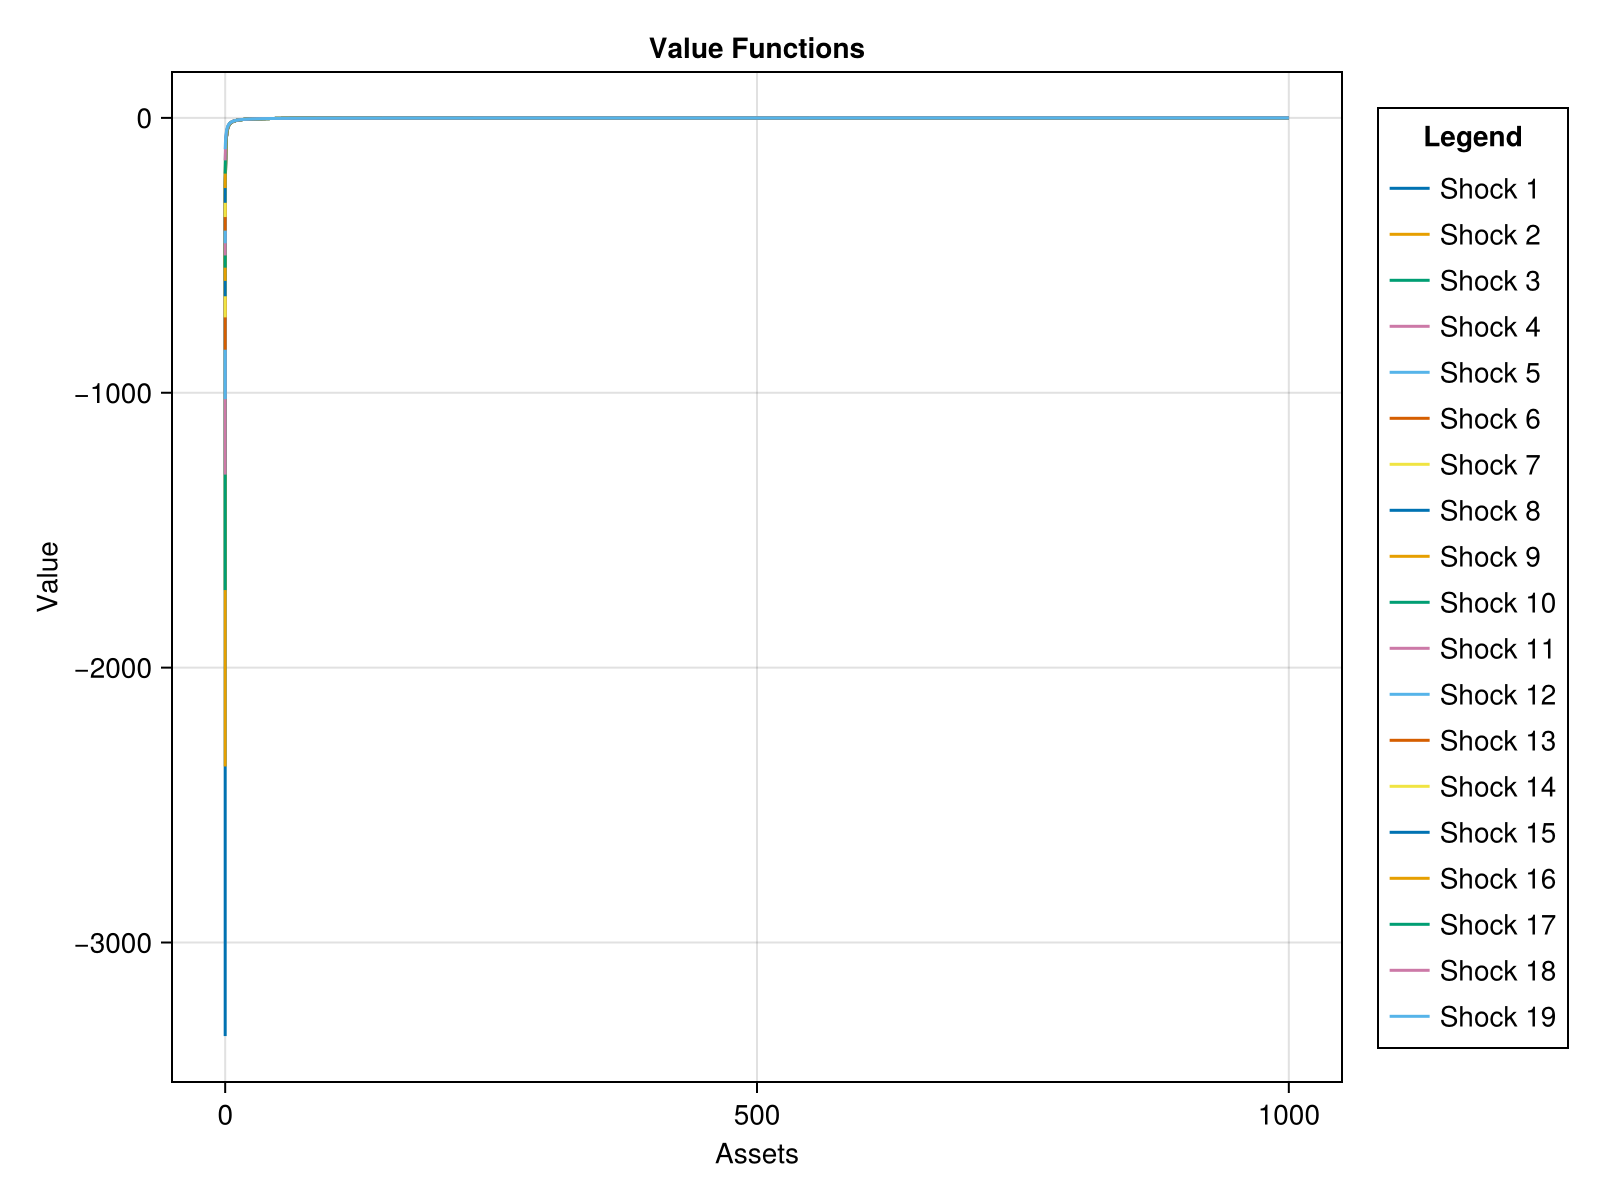

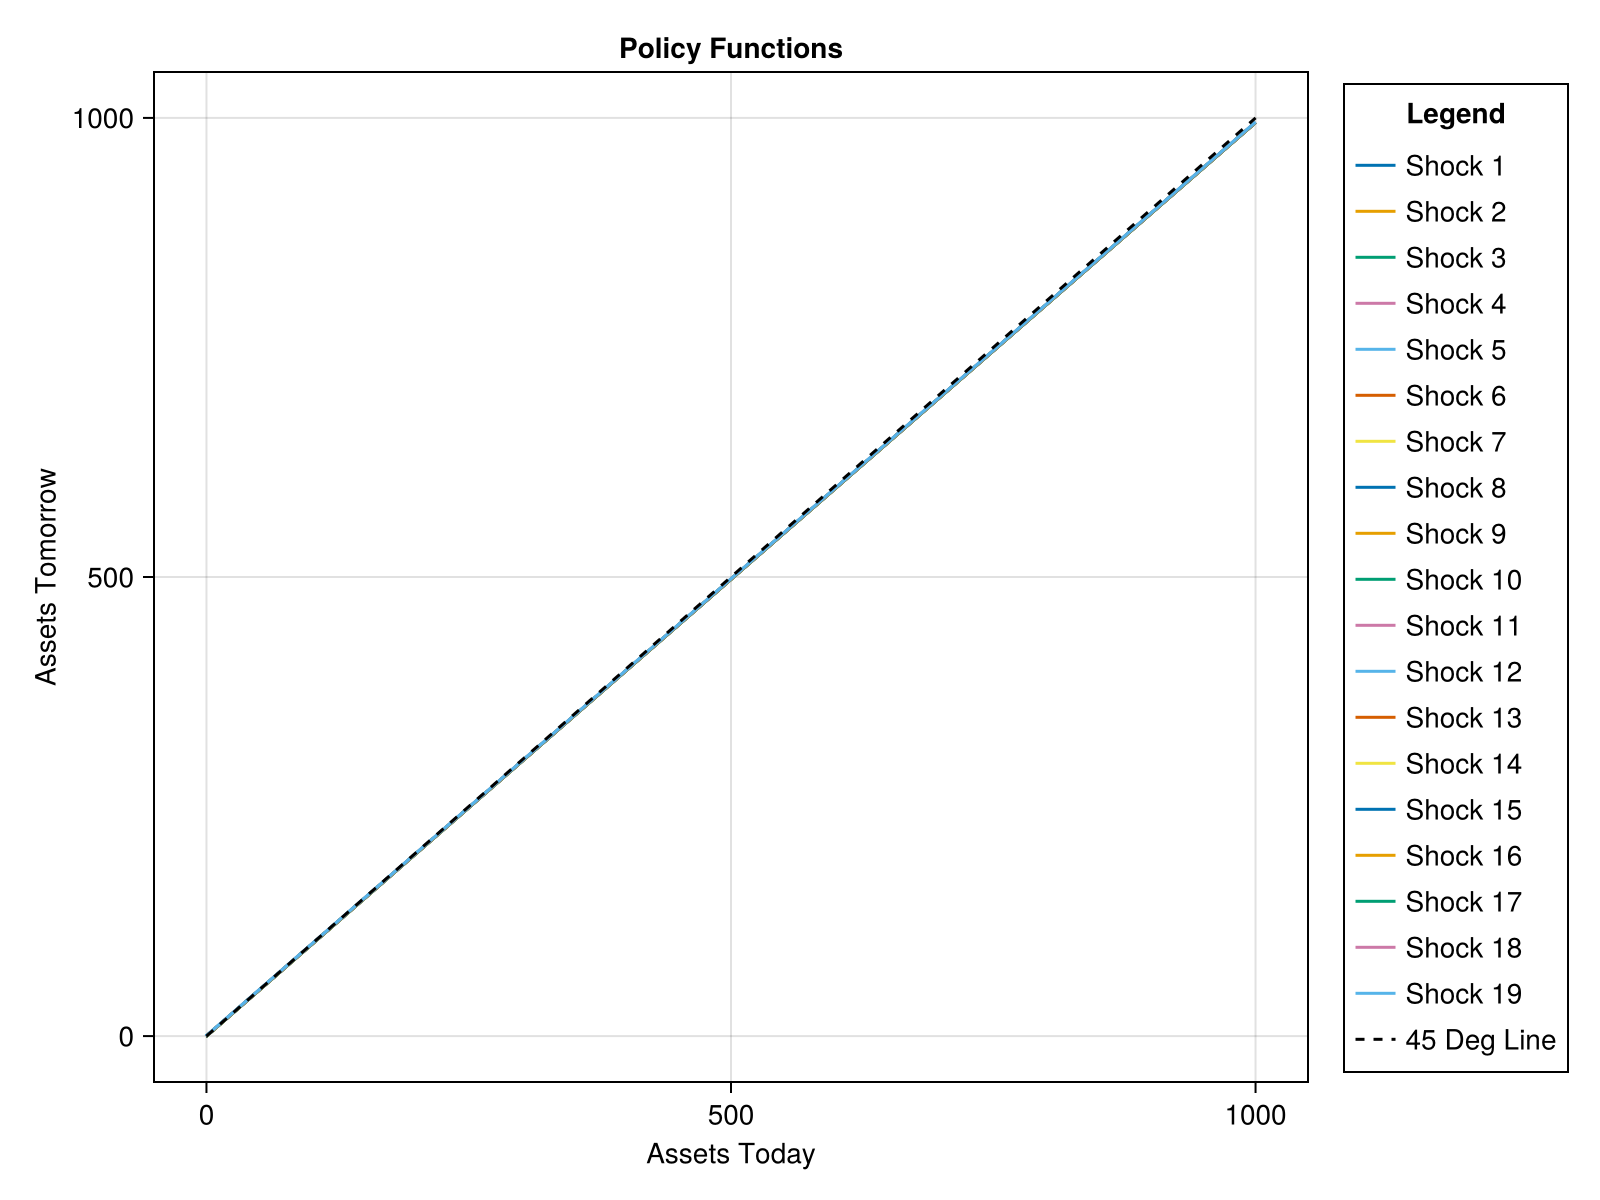

([-3340.4440764246565 -2359.5144614157894 … -154.74082701008044 -113.82727187305419; -3254.5822039198147 -2322.373125102612 … -154.73839505801917 -113.82596584443954; … ; -0.10381596010666773 -0.1038159418100725 … -0.10376905921396871 -0.10374427261403621; -0.09972633729455287 -0.09972632041106394 … -0.09968305776433571 -0.09966018424640868], [3.4364336880663596e-16 3.136039484770566e-16 … 0.41078970144991783 0.6388989504094262; 3.6056660035099225e-16 3.246335394581421e-16 … 0.41079963548559056 0.6389089000650485; … ; 955.7575163771832 955.7576848048747 … 956.189474547194 956.4179177139191; 994.9642676386349 994.9644362352404 … 995.3966544596898 995.6253285763673])

In [8]:
function vfi(v_init, pars)
    (; maxiter, toler, nz, na, print_skip) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v_init = ones(pars.na, pars.nz)
pol_init = ones(pars.na, pars.nz)

@time begin
v_out, pol_out = vfi(v_init, pars)
end

Iterating...
--------------------
Iteration: 0, Error: 3.607873644333405e-6
--------------------
Converged in 2 iterations
--------------------
  1.105413 seconds (2.92 M allocations: 176.488 MiB, 2.09% gc time, 38.05% compilation time)


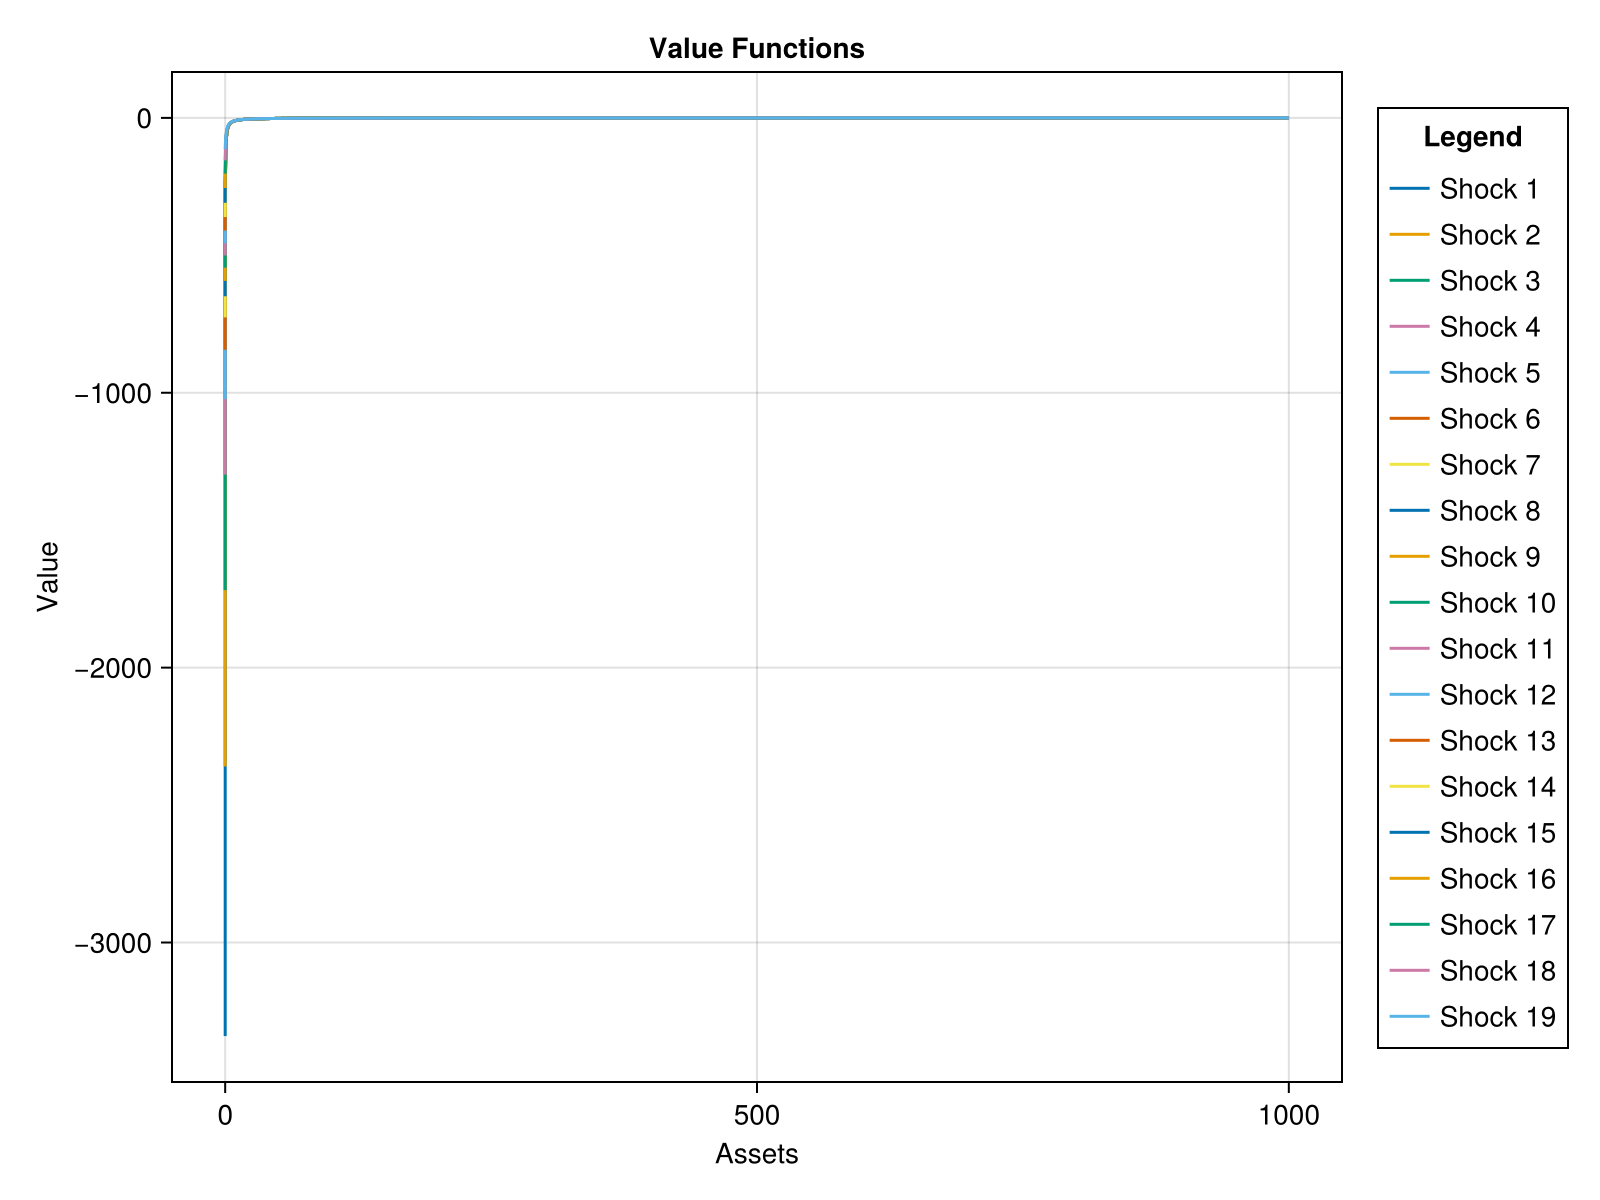

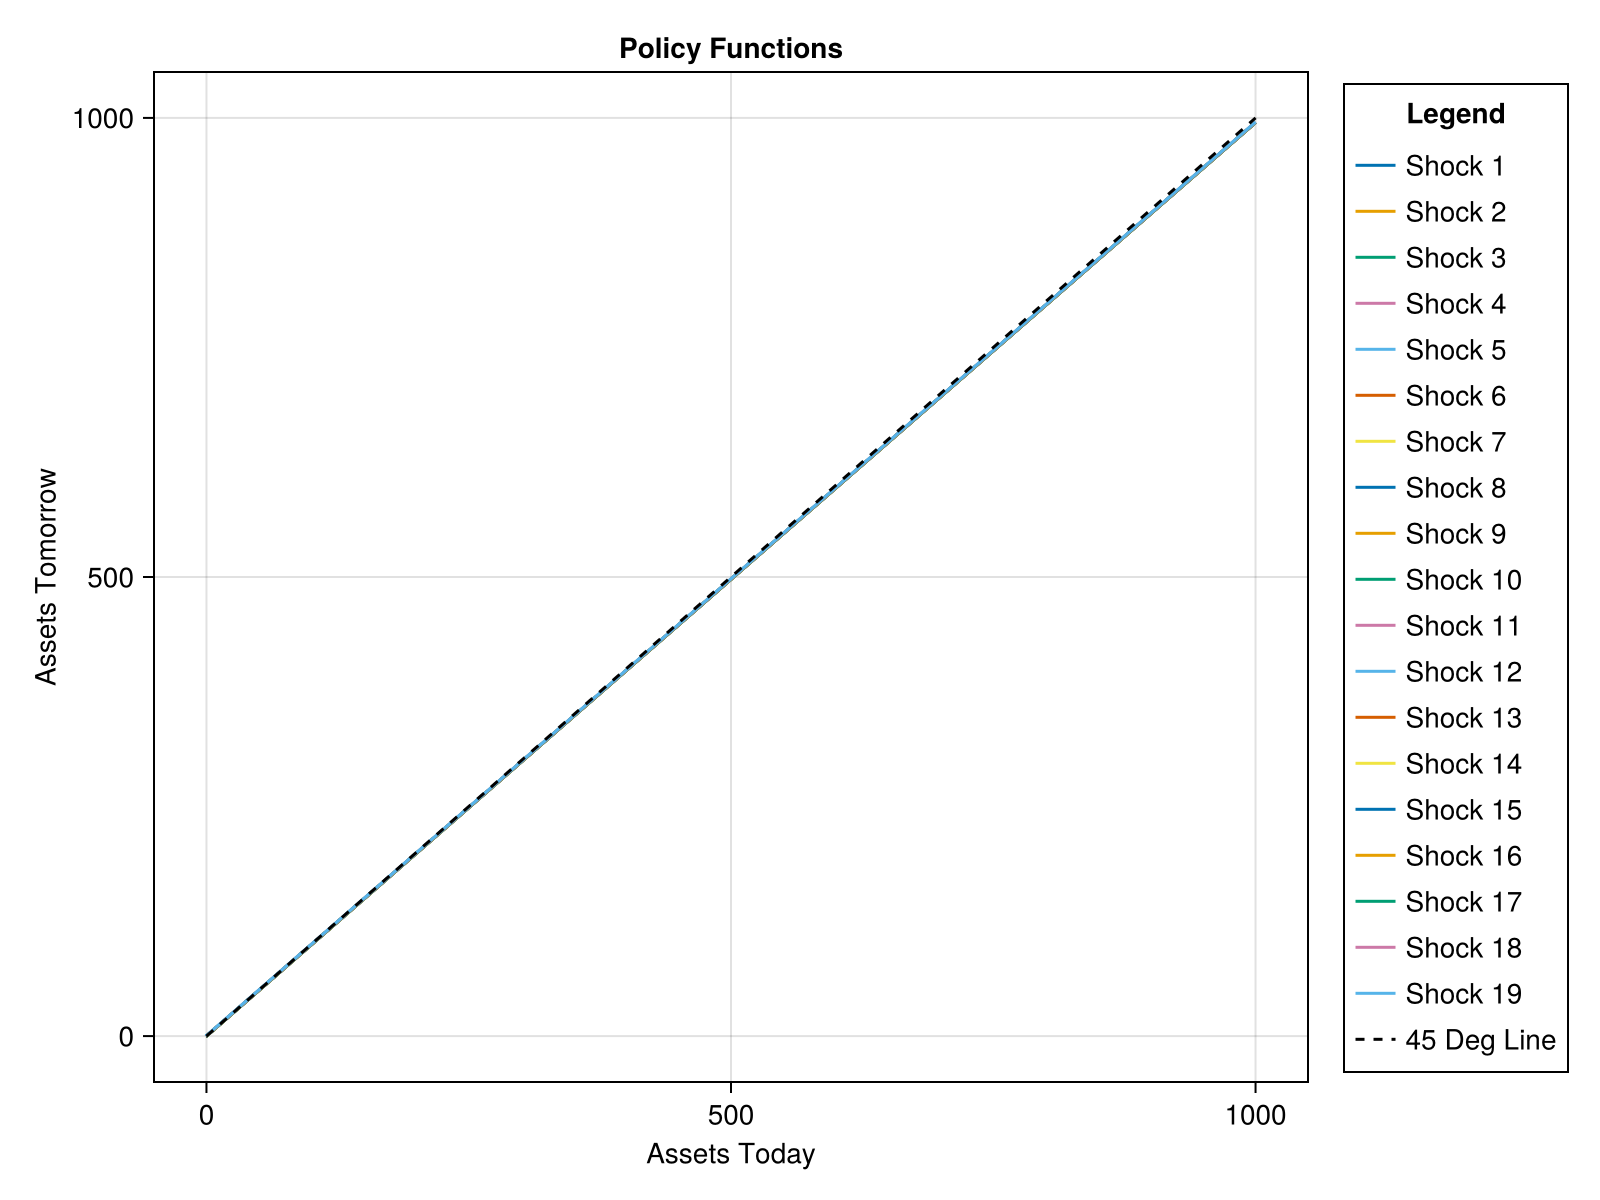

([-3340.4444284075153 -2359.514813398648 … -154.74115089552615 -113.82756523865606; -3254.5825559026734 -2322.3734770854708 … -154.73871894227418 -113.82625920862785; … ; -0.10381737982138096 -0.10381736152471416 … -0.10377047874520337 -0.10374569204830282; -0.09972774100525238 -0.09972772412169731 … -0.09968446130555264 -0.09966158769804967], [3.4364336880701974e-16 3.136039484779054e-16 … 0.4107897179177658 0.6388990000732849; 3.605666003512516e-16 3.2463353945904634e-16 … 0.4107996519427259 0.6389089497290781; … ; 955.7577136994565 955.7578821517237 … 956.189671962854 956.4181151891876; 994.9644732744779 994.964641875603 … 995.3968601891779 995.625534359887])

In [9]:
function hpi(v_init, policy, pars)
    (; maxiter, toler, print_skip) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        v_new = howard(v_new, policy, Π, Avals, Zvals, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end
        
@time begin
    hpi_v, hpi_pol = hpi(v_init, pol_init, pars)
end    

In [39]:
p = (;r = 0.1, # interest rate
    w = 0.015, # wage   
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion (recall that this must be greater than 1 in the CES formulation)
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    how_iter = 50, # number of Howard iterations
    print_skip = 100, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 10000.0) # upper bound of capital grid

(r = 0.1, w = 0.015, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, θ = 4.0, toler = 4.0e-7, maxiter = 1000, how_iter = 50, print_skip = 100, lb = 0.0, ub = 10000.0)

In [41]:
function utility_CES(c, p)
    (; γ) = p
    return c^(1-γ)
end

function interpV_CES(Avals, v_slice, p)
    (; γ) = p
    interp_v = Spline1D(Avals, v_slice, k=1, bc="extrapolate")
    transformed_interp(x) = interp_v(x)^(1.0-γ)
    return transformed_interp
end

function optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
    (; β, na, nz, lb, γ) = p
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV_CES(Avals, expected_value, p)
        for j in 1:na
            obj_CES(ap) = - (((1-β) * utility_CES(resources(Avals, Zvals, j, i, p) - ap, p) + β * interpolation(ap))^(1/(1-γ)))
            ub = resources(Avals, Zvals, j, i, p)  
            res = optimize(obj_CES, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

function howard_CES(v, policy, Π, Agrid, Zgrid, p)
    (; β, na, nz, how_iter, γ) = p
    for _ in 1:how_iter
        for j in 1:nz
            exp_val = v * Π[j,:]
            interp_e_val = interpV_CES(Agrid, exp_val, p)
            for i in 1:na
                obj_CES(ap) = (((1-β) * utility_CES(resources(Agrid, Zgrid, i, j, p) - ap, p) + β * interp_e_val(ap)))^(1/(1-γ))
                v[i,j] = obj_CES(policy[i,j])
            end
        end
    end
    return v
end  

howard_CES (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 0.9934324089935621
--------------------
Iteration: 100, Error: 0.0025952474447686813
--------------------
Converged in 185 iterations
--------------------
  2.249478 seconds (2.36 M allocations: 222.336 MiB, 2.01% gc time, 20.25% compilation time)


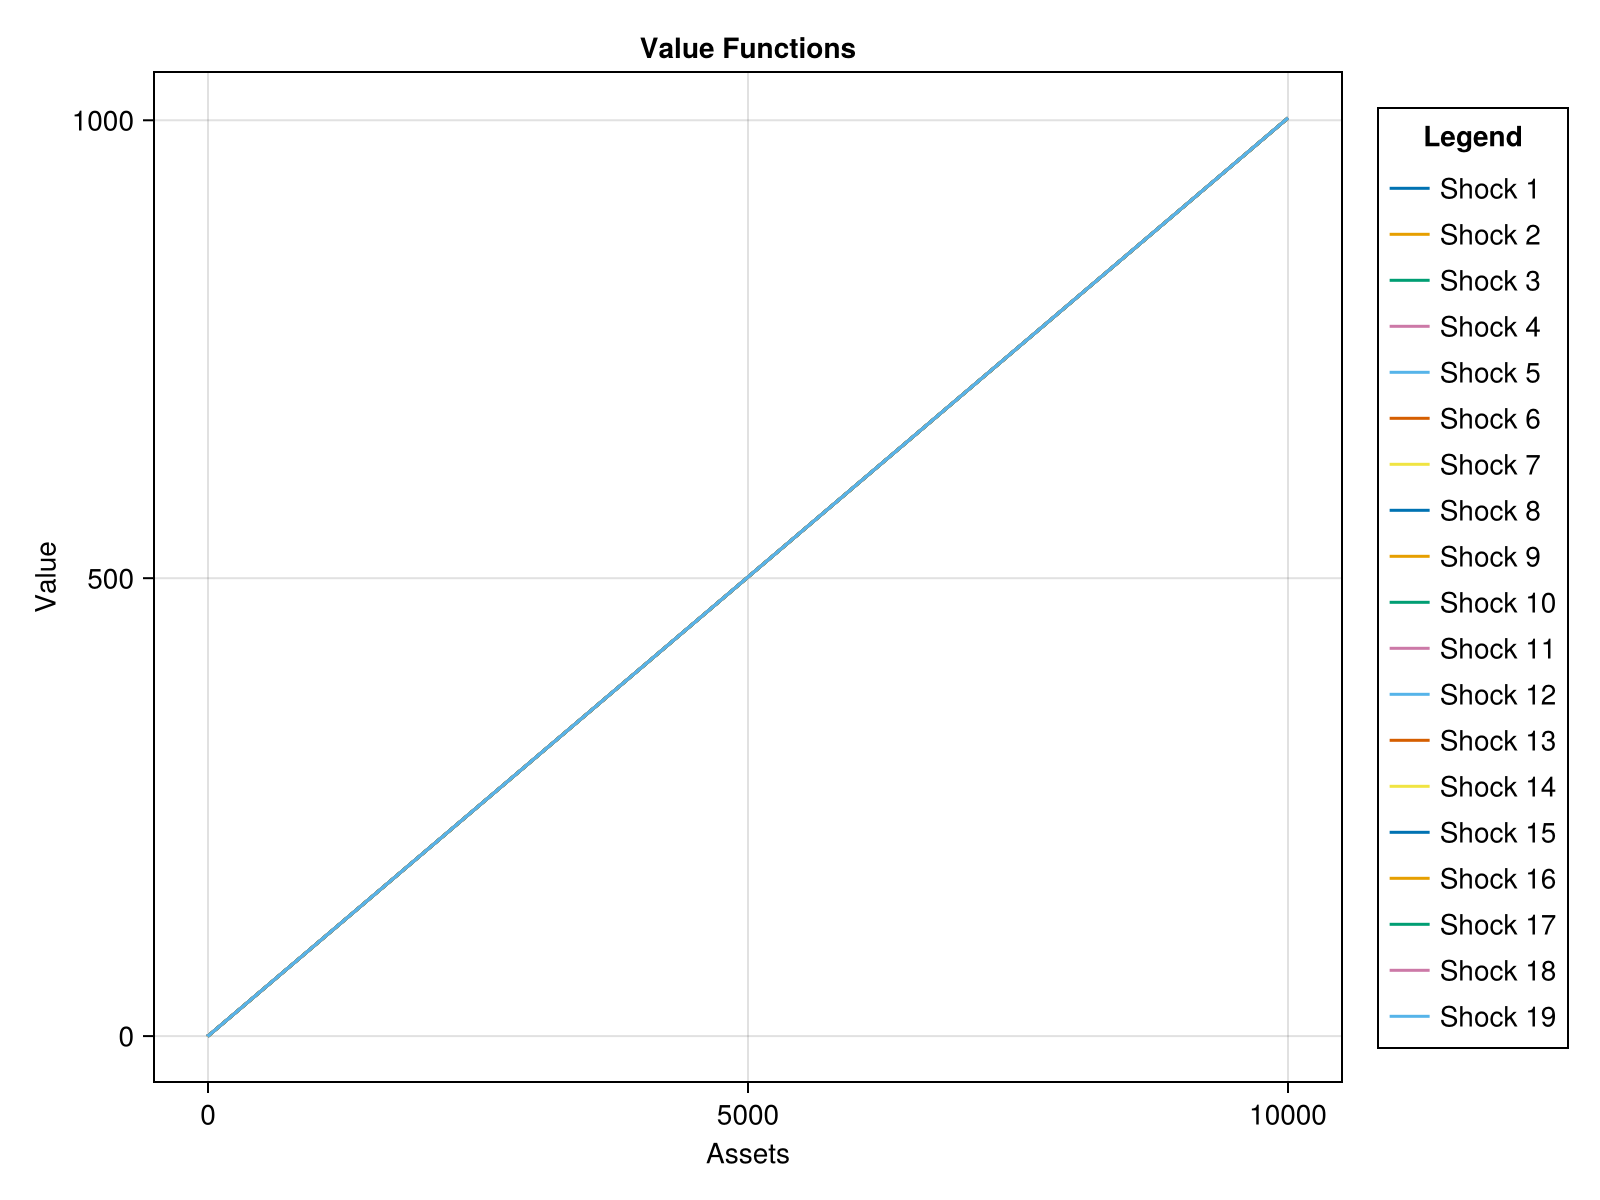

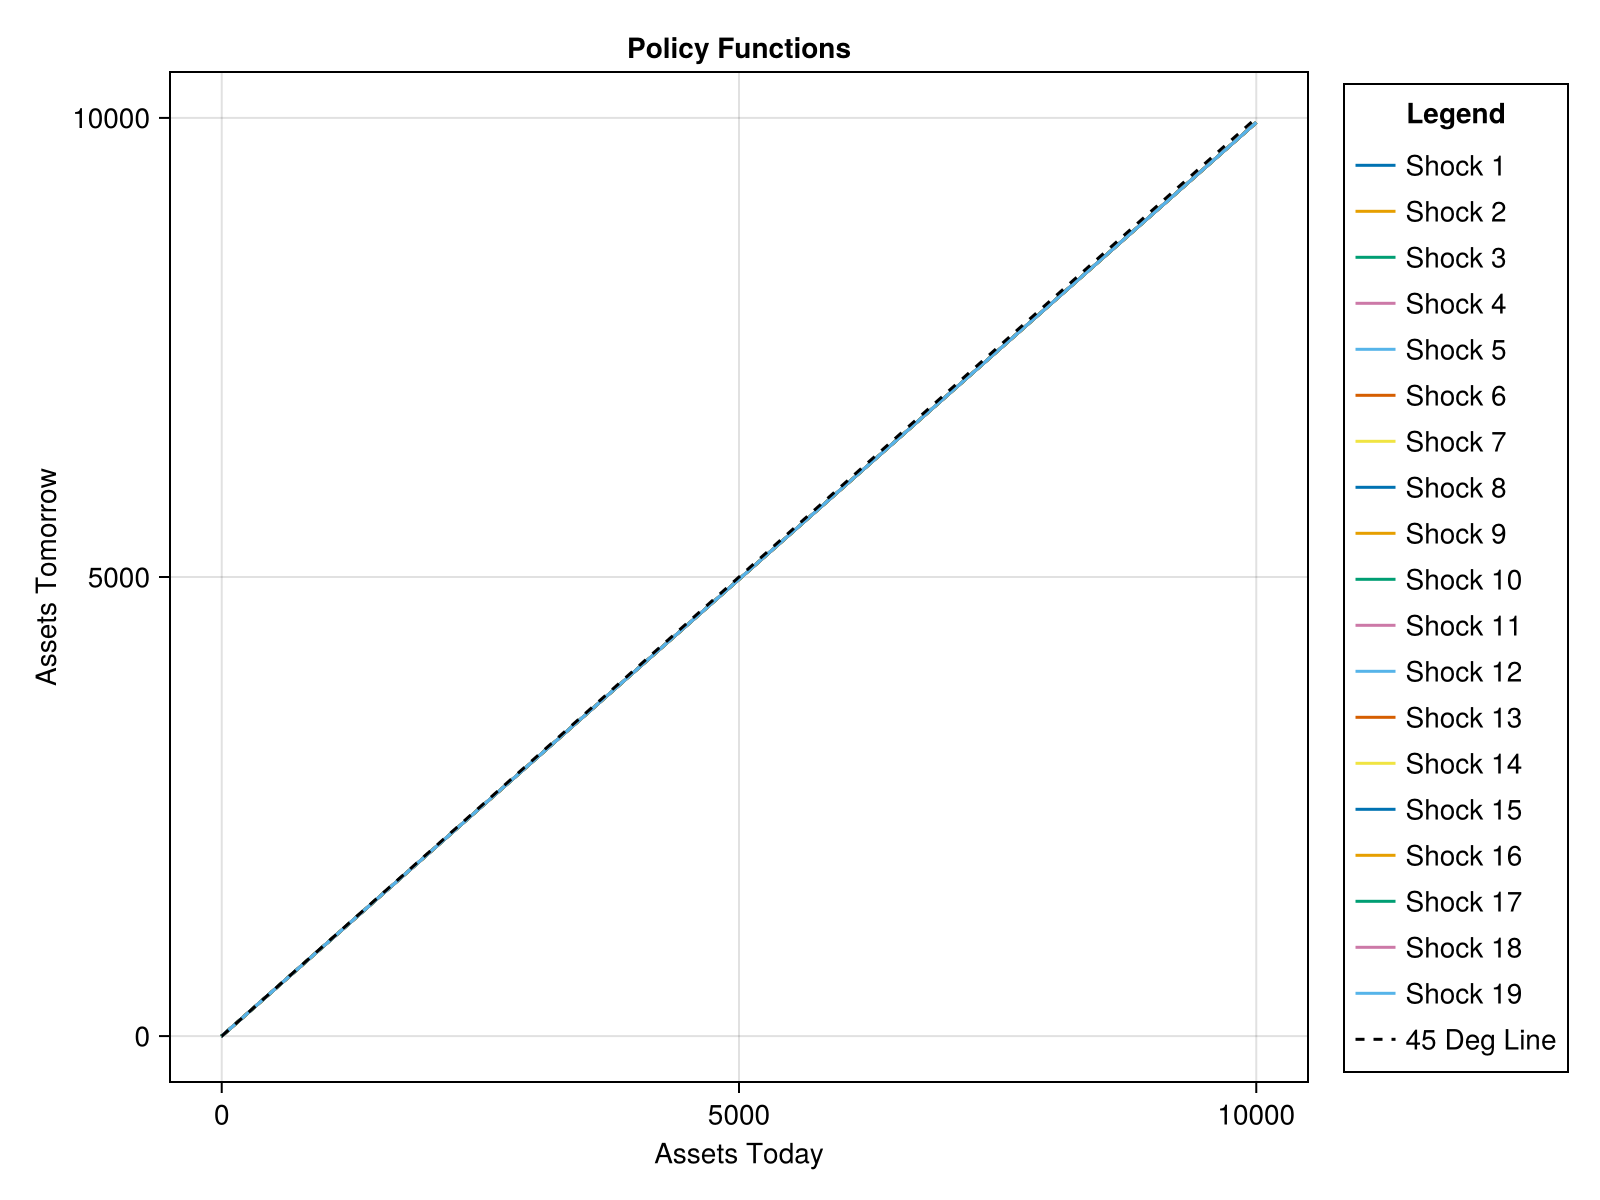

([0.002856242539379452 0.004073687608387233 … 0.061289251736405224 0.08290888586524203; 0.0036425931022975697 0.004760355833867607 … 0.06129932667326769 0.08291892251213104; … ; 963.0268709932808 963.0268869082162 … 963.0676853011047 963.0892701557676; 1002.5295960250245 1002.5296119399559 … 1002.5704103217766 1002.591995170584], [4.043884594224773e-16 3.820028971959754e-16 … 0.3841243693032847 0.598208791315525; 3.169600042961959e-16 2.431556463131168e-16 … 0.38422384198657106 0.5983082840242292; … ; 9557.78850681961 9557.788665636768 … 9558.193589287192 9558.407820284496; 9949.853261282875 9949.85341982777 … 9950.258344274203 9950.472574617654])

In [42]:
function vfi_CES(v_init, p)
    (; maxiter, toler, nz, na, print_skip) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:p.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:p.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v2 = ones(p.na, p.nz)

@time begin
v_ces, pol_ces = vfi_CES(v2, p)
end

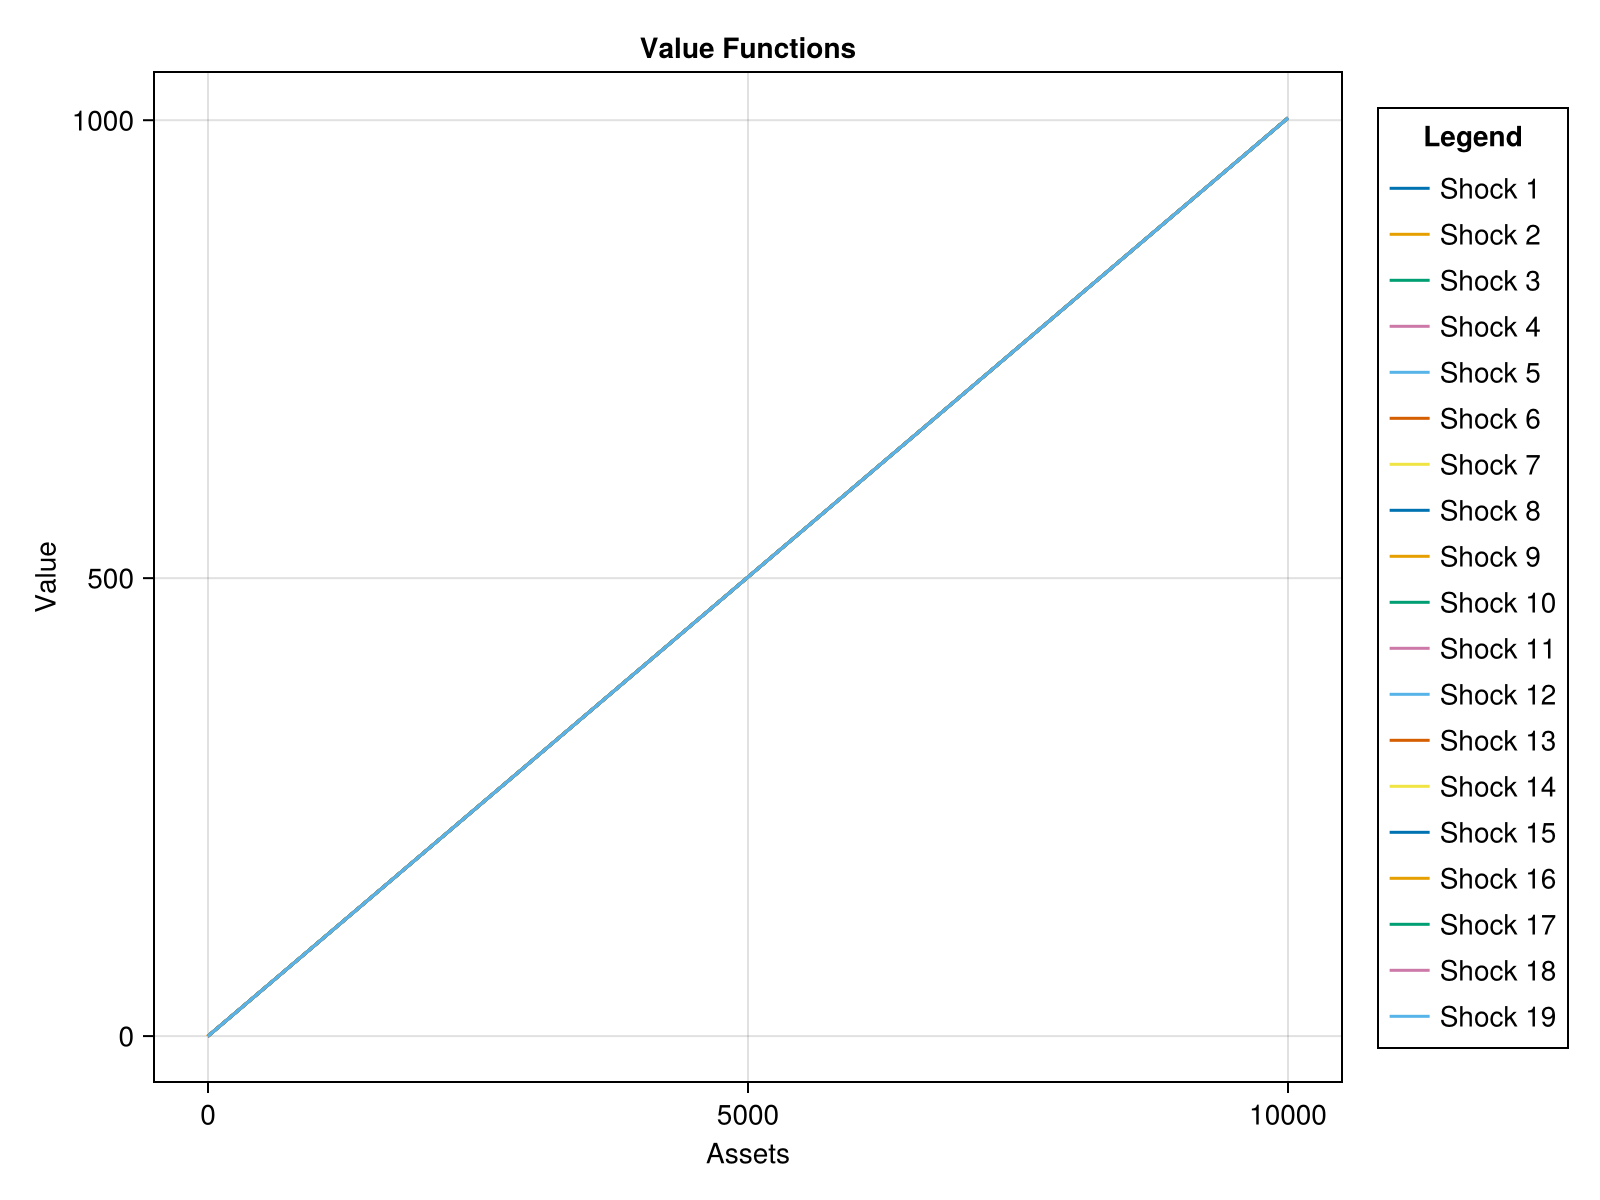

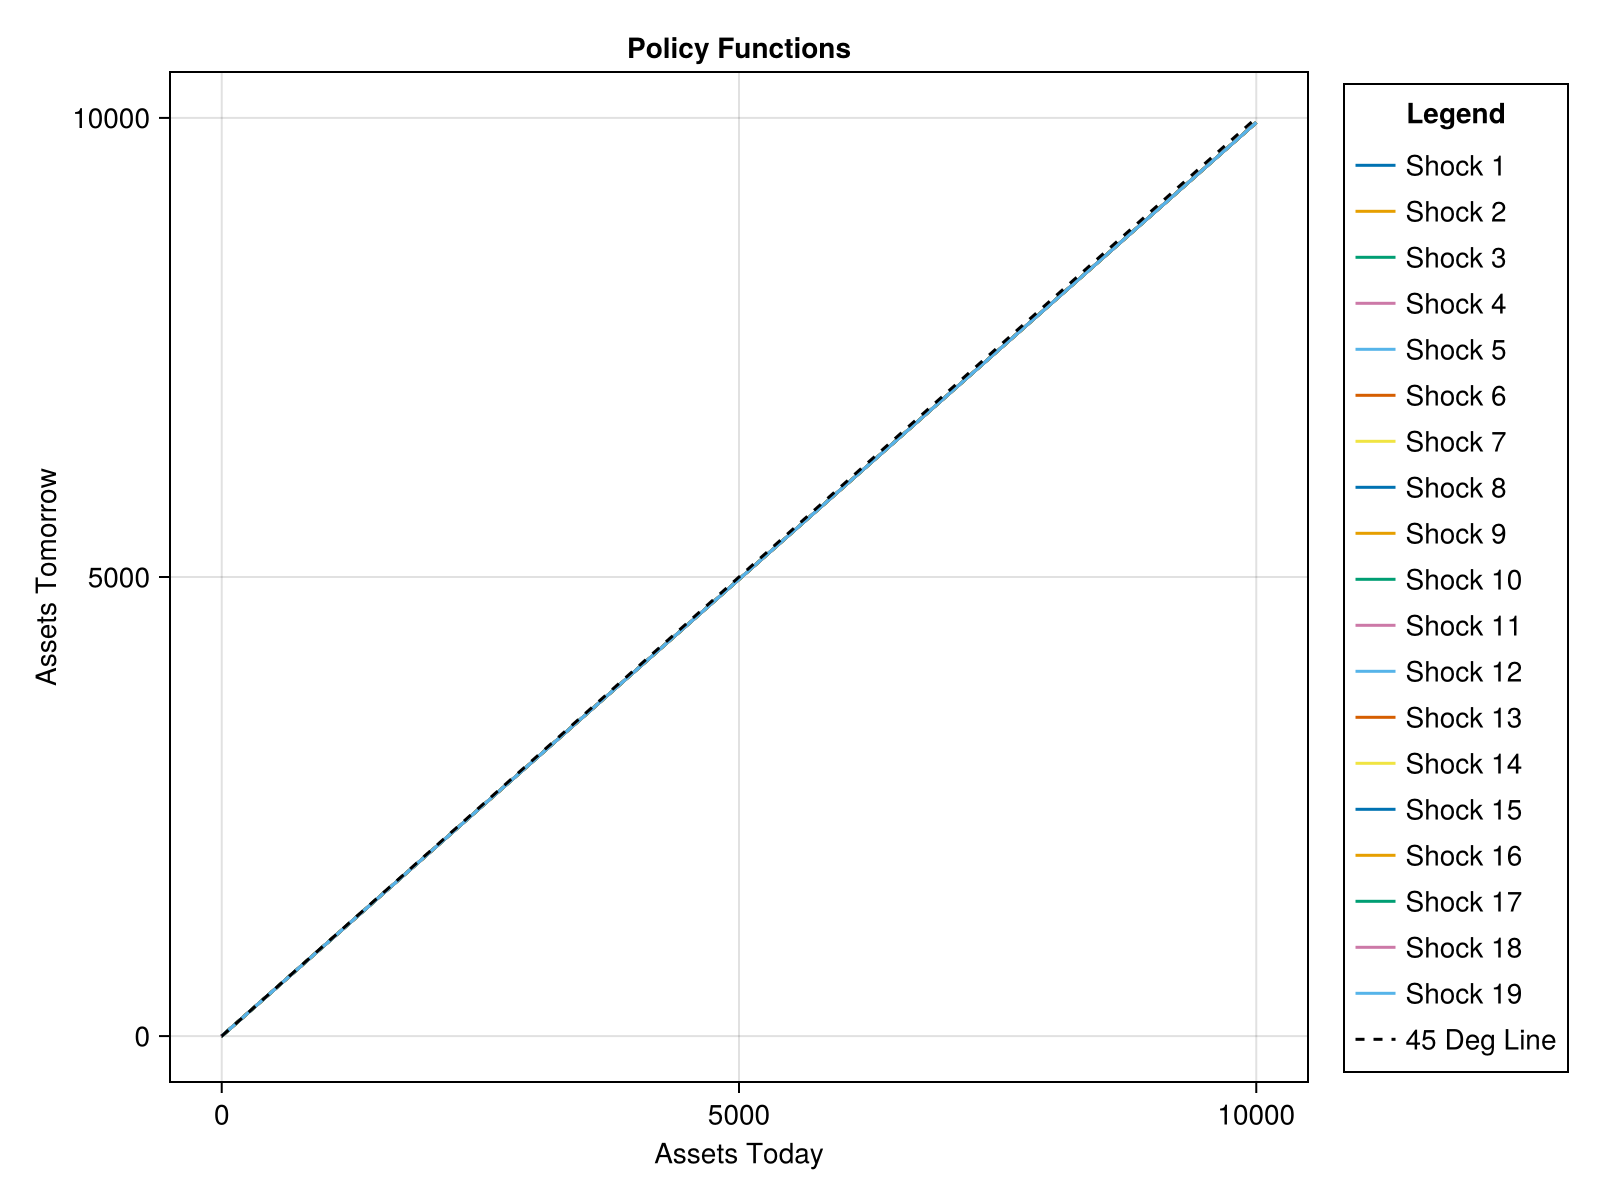

Iterating...
--------------------
Iteration: 0, Error: 3.4964322036165427e-6
--------------------
Converged in 2 iterations
--------------------
  1.001389 seconds (1.54 M allocations: 133.440 MiB, 13.72% gc time, 20.30% compilation time)


([0.00022778501518729138 0.00032444376263955177 … 0.0048923424216540485 0.006625576779365963; 0.0007461395957700518 0.0007860688301051357 … 0.0049024049040264 0.0066356392617383155; … ; 963.0112251699823 963.0112264431854 … 963.0144903362032 963.0162171359937; 1002.5142207950028 1002.5142220682056 … 1002.5174859612237 1002.5192127610144], [3.584719042760056e-16 3.263364955188156e-16 … 0.030738069460268205 0.047873082100511034; 4.3712589514938646e-16 2.598402837395313e-16 … 0.030837548650554027 0.04797256129653074; … ; 9557.807926864063 9557.807939724082 … 9557.840333292215 9557.857471671516; 9949.872677007745 9949.8726903714 … 9949.905084459784 9949.922221956136])

In [38]:
function hpi_CES(v_init, p)
    (; maxiter, toler, nz, na, print_skip) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
        v_new = howard_CES(v_new, policy, Π, Avals, Zvals, p)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:p.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:p.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

@time begin
    hpi_v_CES, hpi_pol_CES = hpi_CES(v2, p)
end    